In [84]:
%pip install matplotlib numpy imageio IPython

Note: you may need to restart the kernel to use updated packages.


In [85]:
from pygltflib import GLTF2, Scene, BufferFormat
from pygltflib.validator import validate, summary
import pathlib
import struct
import numpy
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import imageio
from IPython.display import display, Image
import os
from pygltflib import BufferView,Accessor,Attributes,Buffer,Node,Mesh,Primitive
import base64
import uuid

In [86]:
model_name = 'pony_cartoon'

In [87]:
glb_filename = f"./asset/{model_name}.glb"
gltf = GLTF2().load(glb_filename)
validate(gltf)

/Users/uitoshen/Documents/GitHub/jellyfish/.venv/lib/python3.10/site-packages/pygltflib/validator.py:121: UserWarning: pygltf.utils.validator is a provisional function and may not exist in future versions.
  warnings.warn("pygltf.utils.validator is a provisional function and may not exist in future versions.")


[]

In [88]:
def accessor_type_size(accessor_type):
    """Return the size based on the accessor type."""
    sizes = {
        "SCALAR": 1,
        "VEC2": 2,
        "VEC3": 3,
        "VEC4": 4,
        "MAT2": 4,
        "MAT3": 9,
        "MAT4": 16
    }
    return sizes.get(accessor_type, 1)

def accessor_component_type_size(component_type):
    """Return the size in bytes based on the component type."""
    sizes = {
        5120: 1,  # BYTE
        5121: 1,  # UNSIGNED_BYTE
        5122: 2,  # SHORT
        5123: 2,  # UNSIGNED_SHORT
        5125: 4,  # UNSIGNED_INT
        5126: 4   # FLOAT
    }
    return sizes.get(component_type, 1)

In [89]:
def decode_binary_data(data, accessor_type, component_type):
    format_char = {
        5120: 'b',  # BYTE
        5121: 'B',  # UNSIGNED_BYTE
        5122: 'h',  # SHORT
        5123: 'H',  # UNSIGNED_SHORT
        5125: 'I',  # UNSIGNED_INT
        5126: 'f'   # FLOAT
    }

    # Number of components per element (e.g., 3 for VEC3)
    num_components = accessor_type_size(accessor_type)

    # Format string for a single element
    element_format = format_char[component_type] * num_components

    # Size in bytes of a single element
    element_size = struct.calcsize(element_format)

    # Decode data
    decoded_data = []
    for i in range(0, len(data), element_size):
        decoded_data.append(struct.unpack(element_format, data[i:i+element_size]))

    return decoded_data

In [90]:

def visualize_vectors(decoded_vectors, accessor_type, elev=None, azim=None):
    if accessor_type == "VEC2":
        x_vals = [vec[0] for vec in decoded_vectors]
        y_vals = [vec[1] for vec in decoded_vectors]
        plt.scatter(x_vals, y_vals)
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('VEC2 Visualization')
        plt.show()

    elif accessor_type == "VEC3":
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        x_vals = [vec[0] for vec in decoded_vectors]
        y_vals = [vec[1] for vec in decoded_vectors]
        z_vals = [vec[2] for vec in decoded_vectors]
        ax.scatter(x_vals, y_vals, z_vals,s=0.001)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        if elev and azim:
            ax.view_init(elev=elev, azim=azim)
        plt.title('VEC3 Visualization')
        plt.show()

In [91]:


def generate_and_display_gif(vector3_tuples):
    # Convert list of tuples to numpy array
    data_np = np.array(vector3_tuples)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data_np[:, 0], data_np[:, 1], data_np[:, 2])

    # Settings for the plot
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

    images = []

    degree = 5

    uid = uuid.uuid4()
    os.makedirs('./temp', exist_ok=True)
    os.makedirs(f'./temp/{uid}', exist_ok=True)
    # Rotate the axes and update the plot to create frames for the GIF
    for angle in range(0, 360, degree):  # Rotating by 5 degrees for each frame
        ax.view_init(30, angle)
        plt.draw()
        filename = f'./temp/{uid}/tmp_{angle}.png'
        plt.savefig(filename)
        images.append(imageio.imread(filename))

    # Create a GIF
    gif_filename = f'./temp/{uid}.gif'
    imageio.mimsave(gif_filename, images, duration=0.1)  # duration is the time for each frame in seconds

    # Display the GIF in the notebook
    with open(gif_filename, 'rb') as f:
        display(Image(data=f.read(), format='png'))


In [92]:
def process(gltf):
    new_buffers = []
    new_buffer_views = []
    new_accessors = []
    new_meshes = []

    current_global_offset = 0
    all_buffer_data = bytearray()

    for mi,mesh in enumerate(gltf.meshes):
        print(f'mesh: {mi}')
        buffer_view_index = 0
        new_primitives = []
        for pi,primitive in enumerate(mesh.primitives):
            print(f'primtive: {pi}',primitive)
            num_vertices = gltf.accessors[primitive.attributes.POSITION].count
            vertex_data = bytearray()  # this will hold the vertex data for this primitive
            attributes = {
                "POSITION": primitive.attributes.POSITION,
                "NORMAL": primitive.attributes.NORMAL,
                "TEXCOORD_0": primitive.attributes.TEXCOORD_0,
                # "JOINTS_0": primitive.attributes.JOINTS_0,
                # "WEIGHTS_0": primitive.attributes.WEIGHTS_0,
            }
            accessors = {
                k: gltf.accessors[v] for k, v in attributes.items() if v is not None
            }
            for vertex_index in range(num_vertices):
                for attribute_name, accessor in accessors.items():
                    buffer_view = gltf.bufferViews[accessor.bufferView]
                    buffer = gltf.buffers[buffer_view.buffer]
                    type_size = accessor_type_size(accessor.type)
                    component_size = accessor_component_type_size(accessor.componentType)
                    byte_stride = buffer_view.byteStride if buffer_view.byteStride else type_size * component_size
                    data_start = (
                        buffer_view.byteOffset
                        + accessor.byteOffset
                        + vertex_index * byte_stride
                    )
                    data_end = data_start + type_size * component_size
                    data = gltf.get_data_from_buffer_uri(buffer.uri)
                    data = data[data_start:data_end]
                    vertex_data.extend(data)

            all_buffer_data.extend(vertex_data)

            vertex_buffer_len = sum(
                accessor_type_size(accessor.type)
                * accessor_component_type_size(accessor.componentType)
                for attr, accessor in accessors.items()
            )  # length of the vertex data for one vertex
            total_buffer_len = len(vertex_data)

            new_buffer_view = BufferView(
                buffer=0,
                byteOffset=current_global_offset,
                byteLength=total_buffer_len,
                byteStride=vertex_buffer_len,
            )
            new_buffer_views.append(new_buffer_view)

            byte_offset = 0
            new_attributes = {}
            for attribute_name, accessor in accessors.items():
                new_accessor = Accessor(
                    bufferView=new_buffer_views.index(new_buffer_view),
                    byteOffset=byte_offset,
                    componentType=accessor.componentType,
                    count=num_vertices,
                    type=accessor.type,
                )
                new_accessors.append(new_accessor)
                byte_offset += accessor_type_size(
                    accessor.type
                ) * accessor_component_type_size(accessor.componentType)
                new_attributes[attribute_name] = new_accessors.index(new_accessor)

            indices_accessor = gltf.accessors[primitive.indices]
            if indices_accessor is not None:
                buffer_view = gltf.bufferViews[indices_accessor.bufferView]
                buffer = gltf.buffers[buffer_view.buffer]
                type_size = accessor_type_size(indices_accessor.type)
                component_size = accessor_component_type_size(
                    indices_accessor.componentType
                )
                data_start = buffer_view.byteOffset + indices_accessor.byteOffset
                data_end = data_start + type_size * component_size * indices_accessor.count
                data = gltf.get_data_from_buffer_uri(buffer.uri)
                data = data[data_start:data_end]
                all_buffer_data.extend(data)

                new_indices_buffer_view = BufferView(
                    buffer=0,
                    byteOffset=total_buffer_len,
                    byteLength=indices_accessor.count
                    * accessor_component_type_size(indices_accessor.componentType)
                    * accessor_type_size(indices_accessor.type),
                )
                new_buffer_views.append(new_indices_buffer_view)
                new_indices_accessor = Accessor(
                    bufferView=new_buffer_views.index(new_indices_buffer_view),
                    componentType=indices_accessor.componentType,
                    count=indices_accessor.count,
                    type=indices_accessor.type,
                )
                new_accessors.append(new_indices_accessor)

            new_primitive = Primitive(
                attributes=Attributes(**new_attributes),
                indices=new_accessors.index(new_indices_accessor)
                if indices_accessor is not None
                else None,
            )
            new_primitives.append(new_primitive)
            new_mesh = Mesh(primitives=new_primitives)
            new_meshes.append(new_mesh)

    new_gltf = GLTF2(
        scene=0,
        scenes=gltf.scenes,
        nodes=gltf.nodes,
        meshes=new_meshes,
        bufferViews=new_buffer_views,
        accessors=new_accessors,
        buffers=[Buffer(byteLength=len(all_buffer_data))],
    )
    new_gltf.set_binary_blob(all_buffer_data)
    return new_gltf

In [93]:
new_gltf = process(gltf)

mesh: 0
primtive: 0 Primitive(extensions={}, extras={}, attributes=Attributes(POSITION=0, NORMAL=1, TANGENT=2, TEXCOORD_0=3, TEXCOORD_1=None, COLOR_0=None, JOINTS_0=None, WEIGHTS_0=None), indices=4, mode=4, material=0, targets=[])
mesh: 1
primtive: 0 Primitive(extensions={}, extras={}, attributes=Attributes(POSITION=5, NORMAL=6, TANGENT=None, TEXCOORD_0=7, TEXCOORD_1=None, COLOR_0=None, JOINTS_0=None, WEIGHTS_0=None), indices=8, mode=4, material=1, targets=[])
mesh: 2
primtive: 0 Primitive(extensions={}, extras={}, attributes=Attributes(POSITION=9, NORMAL=10, TANGENT=11, TEXCOORD_0=12, TEXCOORD_1=None, COLOR_0=None, JOINTS_0=None, WEIGHTS_0=None), indices=13, mode=4, material=2, targets=[])
mesh: 3
primtive: 0 Primitive(extensions={}, extras={}, attributes=Attributes(POSITION=14, NORMAL=15, TANGENT=16, TEXCOORD_0=17, TEXCOORD_1=None, COLOR_0=None, JOINTS_0=None, WEIGHTS_0=None), indices=18, mode=4, material=3, targets=[])


In [94]:
validate(new_gltf)

[]

In [95]:
os.makedirs('./output', exist_ok=True)

In [96]:
output_path = f"./output/{model_name}.glb"

In [97]:
new_gltf.save(output_path)

True

In [98]:
glb = GLTF2.load(output_path)

In [99]:

positions = []

for mesh in gltf.meshes:
    for primitive in mesh.primitives:
        # Check if POSITION is in the attributes
        accessor_index = primitive.attributes.POSITION
        accessor = gltf.accessors[accessor_index]
        
        buffer_view = gltf.bufferViews[accessor.bufferView]
        buffer = gltf.buffers[buffer_view.buffer]
        data = gltf.get_data_from_buffer_uri(buffer.uri)

        # Calculate the real byte offset in the buffer
        byte_offset = accessor.byteOffset + buffer_view.byteOffset
        
        # Use byteStride from bufferView if defined, else calculate it
        byte_stride = buffer_view.byteStride if buffer_view.byteStride else accessor_component_type_size(accessor.componentType) * accessor_type_size(accessor.type)

        # Extract and unpack position data from the interleaved buffer
        for i in range(accessor.count):
            # For simplicity, assuming data is FLOAT and VEC3 for positions
            start = byte_offset + i * byte_stride
            position_tuple = struct.unpack_from('<3f', data, start)
            positions.append(position_tuple)

/var/folders/hl/tl4xswkd0gs6k1jxb815zb5m0000gq/T/ipykernel_7467/1630414462.py:27: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


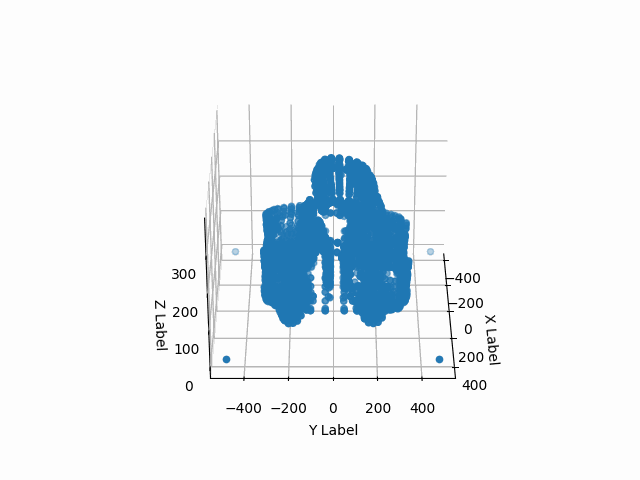

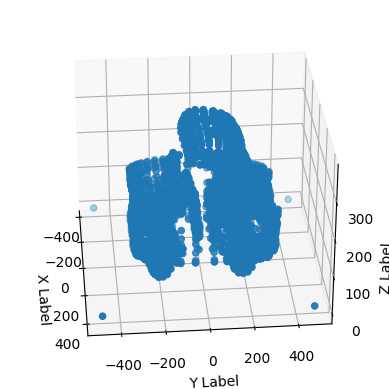

In [100]:
generate_and_display_gif(positions)